In [9]:
import optuna
import optuna
import pandas as pd
import polars as pl
from src.config import  STORAGE_OPTUNA

In [12]:

study = optuna.create_study(
    direction="maximize",
    study_name='no-name-58aad351-e6cd-4a0f-aa54-2821f1033b79',
    storage=STORAGE_OPTUNA,
    load_if_exists=True,
)

[I 2025-10-25 20:21:55,445] Using an existing study with name 'no-name-58aad351-e6cd-4a0f-aa54-2821f1033b79' instead of creating a new one.


In [11]:
optuna.get_all_study_names(storage=STORAGE_OPTUNA)

['no-name-00ae3b02-b5cb-4800-941e-f0ed0ac39072',
 'no-name-f6c8504f-d064-4460-a16e-4a46df2eb928',
 'no-name-509364e2-c5ec-4491-8d2e-0ebec2aff7a6',
 'no-name-cd136572-c2e9-4ab5-afb3-8ab918844768',
 'no-name-b38a5928-dd7a-4954-96bd-1031644ccfd4',
 'no-name-9f257209-8c2b-4454-9c08-8f7787c704e9',
 'no-name-3abb56ad-ae53-49e5-b136-558f846cd9a9',
 'no-name-66ad7ba7-943e-46e3-99bc-aab38cfb686e',
 'no-name-5345e0ab-5652-41c3-a688-083d263a3eeb',
 'no-name-c324a34a-6381-42f1-b5ae-666bc329a1c8',
 'no-name-7e44db5c-5caf-4bfb-92bf-d7d59b70e396',
 'no-name-58aad351-e6cd-4a0f-aa54-2821f1033b79']

In [62]:
k = 5
# Seleccionar top-k trials según 'value'
df_trials = study.trials_dataframe()
topk_df = (
    df_trials.nlargest(k, "value")
    .reset_index(drop=True)
    .loc[:, ["number", "value", "user_attrs_best_iter"]]
)

number_to_trial = {t.number: t for t in study.trials}


In [68]:
param_2 = {}
for top_rank, row in topk_df.iterrows():
    trial_num = int(row["number"])
    trial_val = float(row["value"])
    trial_obj = number_to_trial[trial_num]
    param_2 = param_2.update(trial_obj.params)
    print(trial_obj.params)
    print(param_2)
    print("#################################")

{'num_leaves': 1540, 'learning_rate': 0.018702141562938528, 'min_data_in_leaf': 42, 'feature_fraction': 0.38407047019941504, 'bagging_fraction': 0.7311177978444481, 'lambda_1': 2.4586912457761425, 'lambda_2': 7.568057448807794}
None
#################################


AttributeError: 'NoneType' object has no attribute 'update'

In [73]:
for top_rank, row in topk_df.iterrows():
    trial_num = int(row["number"])
    trial_val = float(row["value"])
    trial_obj = number_to_trial[trial_num]
    print(trial_obj.user_attrs.get("best_iter"))

12
24
324
24
18


In [ ]:
import lightgbm as lgb
from pathlib import Path
import json

In [74]:

def train_model(X_train, y_train, weights):
    # Datos a entrenar
    train_data = lgb.Dataset(X_train, label=y_train, weight=weights)

    # Path donde se guarda modelo entrenado
    save_dir = Path(f"../models/optuna_models_train/")

    # Seteo parámetros fijos
    final_params = {
        'objective': 'binary',
        'metric': 'None',
        'max_bin': 31,
        'verbosity': -1,  # Para suprimir la salida
        'n_jobs': -1      # Para usar todos los cores
    }

    # itero el top de los modelos y guardo la posición en el top y el objeto trial
    experimento = 'train_prueba_de_mentira'

    # array para guardar resumen de modelos y guardar metadata
    resumen_rows= list()

    for top_rank, row in topk_df.iterrows():
        trial_num = int(row["number"])
        trial_val = float(row["value"])
        trial_obj = number_to_trial[trial_num]
        print(trial_val)
        num_boost_round = int(trial_obj.user_attrs.get("best_iter"))
        params = final_params.copy()
        # Obtengo los parámetros del trial
        params.update(trial_obj.params)

        for seed in SEEDS:
            file = f"train_model_lgb_optimization_top_{top_rank + 1}_seed_{seed}_experimento_{experimento}.txt"
            check_path = save_dir / file

            if Path(check_path).exists():
                print(f'Archivo {file} ya existe en directorio')
                pass
            else:

                # Agrgo semilla a params
                params.update({'seed': seed})

                # entrenamiento del modelo
                model = lgb.train(
                    params=params,
                    train_set=train_data,
                    num_boost_round=int(num_boost_round)
                )

                # Guardado
                out_path = save_dir / file
                model.save_model(str(out_path))

                resumen_rows.append({
                    "top_rank": top_rank + 1,
                    "trial_number": trial_num,
                    "trial_value": trial_val,
                    "best_iter": int(num_boost_round),
                    "seed": int(seed),
                    "model_path": str(out_path),
                    "params": json.dumps(params)
                })


    meta = pd.DataFrame(resumen_rows)
    meta_path = save_dir / f"trained_models_metadata_experimento_{experimento}.csv"
    meta.to_csv(meta_path, index=False)

    return meta



NameError: name 'lgb' is not defined

In [ ]:
import numpy as np
import matplotlib as plt

def calculo_curvas_ganancia(dir_model_opt,model_files: list,
                            y_test_class, Xif):
    piso_envios = 4000
    techo_envios = 20000  # exclusivo

    # estilo común
    LINEWIDTH = 1.5
    ALPHA_MODELOS = 0.3  # transparencia para líneas que NO son el promedio
    ALPHA_PROM = 1.0  # promedio sin transparencia
    LS_PROM = '--'  # estilo del promedio

    # ----- figura única
    plt.figure(figsize=(10, 6))

    curvas = []
    mejores_cortes = {}  # {nombre_modelo: (k_envios, ganancia_max, thr_opt_prob)}
    probs_ordenadas = []  # lista de arrays con y_pred ordenado desc por modelo (para el promedio)

    y_predicciones = []

    for model_file in model_files:
        model = lgb.Booster(model_file=f"{dir_model_opt}{model_file}")
        y_pred = model.predict(Xif)

        #guardo las predicciones en df para poder compararlas entre sí
        df_pred_export = Xif[['numero_de_cliente','foto_mes']].copy()
        df_pred_export['y_pred'] = y_pred
        y_predicciones.append(df_pred_export)

        # ganancia por fila (independiente del modelo)
        ganancia = np.where(y_test_class == "BAJA+2", ganancia_acierto, 0) - \
                   np.where(y_test_class != "BAJA+2", costo_estimulo, 0)

        # ordeno por probabilidad descendente
        idx = np.argsort(y_pred)[::-1]
        y_pred_sorted = y_pred[idx]  # <-- PROBABILIDADES ORDENADAS
        gan_ord = ganancia[idx]  # ganancias alineadas al ranking

        # acumulada y segmento
        gan_cum = np.cumsum(gan_ord)
        curva_segmento = gan_cum[piso_envios:techo_envios]
        curvas.append(curva_segmento)
        probs_ordenadas.append(y_pred_sorted)

        # eje X: cantidad de envíos
        x_envios = np.arange(piso_envios, piso_envios + len(curva_segmento))

        # mejor k (dentro del segmento)
        argmax_local = int(np.argmax(curva_segmento))
        k_mejor = int(piso_envios + argmax_local)
        ganancia_max = float(curva_segmento[argmax_local])

        # Mejor probabilidad de corte
        thr_opt = gan_ord[k_mejor]

        # Umbral de probabilidad en el mejor k (ojo índice 0-based)
        k_idx = max(k_mejor - 1, 0)  # por seguridad si k_mejor==0 (no debería)
        thr_opt = float(y_pred_sorted[k_idx])

        nombre = model_file.replace('.txt', '')
        mejores_cortes[nombre] = (k_mejor, ganancia_max, thr_opt)

        # ploteo curva del modelo
        plt.plot(x_envios, curva_segmento,
                 label=nombre,
                 linewidth=LINEWIDTH,
                 alpha=ALPHA_MODELOS)
        plt.savefig(f'curva_ganancia_modelo_{model_file}')


    # ----- promedio del segmento
    curvas_np = np.vstack(curvas)  # (n_modelos, n_puntos)
    promedio = curvas_np.mean(axis=0)
    x_envios = np.arange(piso_envios, piso_envios + len(promedio))

    x_argmax_local = int(np.argmax(promedio))
    x_k_mejor = int(piso_envios + x_argmax_local)
    x_ganancia_max = float(promedio[x_argmax_local])

    # Umbral promedio en probabilidad en el rank x_k_mejor:
    x_k_idx = max(x_k_mejor - 1, 0)
    # tomamos la probabilidad en ese rank para cada modelo y promediamos
    x_thr_opt = float(np.mean([p_sorted[x_k_idx] for p_sorted in probs_ordenadas]))

    plt.plot(x_envios, promedio,
             linewidth=LINEWIDTH,
             linestyle=LS_PROM,
             alpha=ALPHA_PROM,
             label=f'Promedio (n={len(model_files)})',
             zorder=5)
    plt.axvline(x=x_k_mejor, linestyle=':', linewidth=LINEWIDTH)

    # ----- decorado
    plt.title('Curvas de Ganancia - Modelos LGBM (eje: cantidad de envíos)')
    plt.xlabel('Cantidad de envíos (top-k)')
    plt.ylabel('Ganancia acumulada')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'promedio_curva_ganancia_modelo_{model_file}')

    # Salida normalizada (incluye probabilidad de corte)
    mejores_cortes_normalizado = {
        nombre: {'k': int(k), 'ganancia': float(g), 'thr_opt': float(thr)}
        for nombre, (k, g, thr) in mejores_cortes.items()
    }

    # Agrego el mejor corte del promedio
    mejores_cortes_normalizado['PROMEDIO'] = {
        'k': int(x_k_mejor),
        'ganancia': float(x_ganancia_max),
        'thr_opt': float(x_thr_opt)
    }

    print(mejores_cortes_normalizado)
    return y_predicciones,curvas, mejores_cortes_normalizado


### Testeo lectura modelos para entrnar y predecir

In [75]:
import pandas as pd
import lightgbm as lgb
from lightgbm import Booster

In [81]:
df_trains_models = pd.read_csv('/home/joacosk/Documents/maestria/Q2/script_project/src/models/lgb_optimization_exp1/lgb_optimization_exp1.csv')

In [87]:
df_trains_models.columns

Index(['modelo', 'k_opt', 'ganancia_max', 'thr_opt', 'timestamp'], dtype='object')

In [94]:
sort_df = df_trains_models.sort_values(by='ganancia_max', ascending=False)

# calcular ganancia acumulada
sort_df.reset_index(inplace=True)

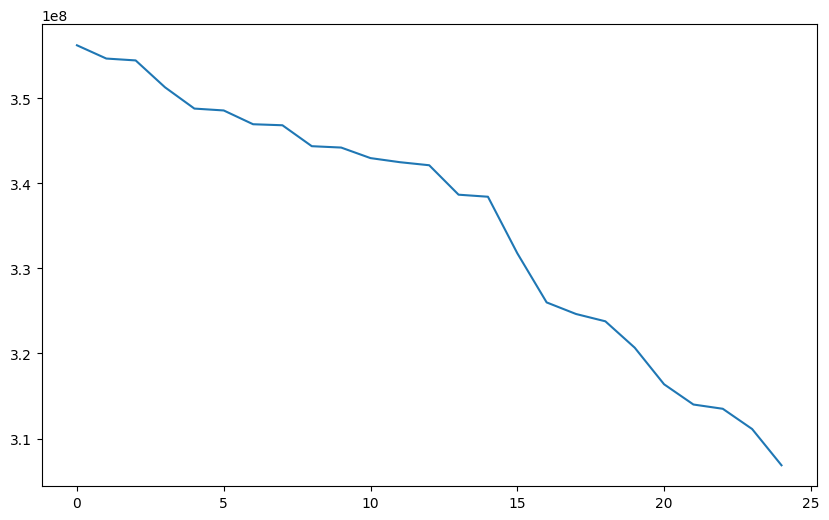

In [95]:
import matplotlib.pyplot as plt
# graficar evolución de ganancia_max
plt.figure(figsize=(10,6))
plt.plot(sort_df.ganancia_max)

In [97]:
sort_df.head(10)

,index,modelo,k_opt,ganancia_max,thr_opt,timestamp
0,7,train_model_lgb_optimization_top_2_seed_515151...,11068,356220000.0,0.000716,2025-10-27 23:08:19
1,22,train_model_lgb_optimization_top_5_seed_515151...,10506,354660000.0,0.009628,2025-10-27 23:09:13
2,23,train_model_lgb_optimization_top_5_seed_551155...,8917,354440000.0,0.013190,2025-10-27 23:09:15
3,20,train_model_lgb_optimization_top_5_seed_151515...,11195,351280000.0,0.008087,2025-10-27 23:09:09
4,24,train_model_lgb_optimization_top_5_seed_555555...,9480,348780000.0,0.011995,2025-10-27 23:09:17
5,0,train_model_lgb_optimization_top_1_seed_151515...,10211,348560000.0,0.001386,2025-10-27 23:07:59
6,3,train_model_lgb_optimization_top_1_seed_551155...,10612,346940000.0,0.001291,2025-10-27 23:08:08
7,21,train_model_lgb_optimization_top_5_seed_155555...,11818,346820000.0,0.007168,2025-10-27 23:09:11
8,6,train_model_lgb_optimization_top_2_seed_155555...,11141,344360000.0,0.000748,2025-10-27 23:08:16
9,4,train_model_lgb_optimization_top_1_seed_555555...,11949,344200000.0,0.000974,2025-10-27 23:08:11


In [99]:
modelos = list(sort_df.modelo)

In [102]:
for modelo in modelos:
    path = '/home/joacosk/Documents/maestria/Q2/script_project/src/models/'+'lgb_optimization_exp1/'+modelo+'.txt'
    model = lgb.Booster(model_file=path)



['active_quarter', 'active_quarter_lag_0', 'cliente_vip', 'cliente_vip_lag_1', 'internet', 'internet_lag_2', 'cliente_edad', 'cliente_edad_lag_3', 'cliente_antiguedad', 'cliente_antiguedad_lag_4', 'mrentabilidad', 'mrentabilidad_lag_5', 'mrentabilidad_annual', 'mrentabilidad_annual_lag_6', 'mcomisiones', 'mcomisiones_lag_7', 'mactivos_margen', 'mactivos_margen_lag_8', 'mpasivos_margen', 'mpasivos_margen_lag_9', 'cproductos', 'cproductos_lag_10', 'tcuentas', 'tcuentas_lag_11', 'ccuenta_corriente', 'ccuenta_corriente_lag_12', 'mcuenta_corriente_adicional', 'mcuenta_corriente_adicional_lag_13', 'mcuenta_corriente', 'mcuenta_corriente_lag_14', 'ccaja_ahorro', 'ccaja_ahorro_lag_15', 'mcaja_ahorro', 'mcaja_ahorro_lag_16', 'mcaja_ahorro_adicional', 'mcaja_ahorro_adicional_lag_17', 'mcaja_ahorro_dolares', 'mcaja_ahorro_dolares_lag_18', 'cdescubierto_preacordado', 'cdescubierto_preacordado_lag_19', 'mcuentas_saldo', 'mcuentas_saldo_lag_20', 'ctarjeta_debito', 'ctarjeta_debito_lag_21', 'ctarjeta

In [105]:
DB_PATH

'data/churn.duckdb'

In [109]:
from src.loader import select_c01
from src.config import DB_PATH
data = select_c01('/home/joacosk/Documents/maestria/Q2/script_project/data/churn.duckdb')

In [111]:
from src.features import (get_numeric_columns_pl,
                          feature_engineering_lag,
                          feature_engineering_delta)
from src.optimization import (binary_target,
                              split_train_data,
                              run_study)
#############################
#### FEATURE ENGINEERING ####
############################
# Creación Lags
numeric_cols = get_numeric_columns_pl(data, exclude_cols=["numero_de_cliente","foto_mes"])
data = feature_engineering_lag(
    data,
    numeric_cols,
    cant_lag=1,
)

# Creación DEltas
data = feature_engineering_delta(data, numeric_cols,1)

################################
#### FIN FEATURE ENGINEERING ####
################################

data = binary_target(data)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [123]:
# seleccionar las columnas model.feature_name() en data
data = data.select(model.feature_name())


active_quarter,active_quarter_lag_0,cliente_vip,cliente_vip_lag_1,internet,internet_lag_2,cliente_edad,cliente_edad_lag_3,cliente_antiguedad,cliente_antiguedad_lag_4,mrentabilidad,mrentabilidad_lag_5,mrentabilidad_annual,mrentabilidad_annual_lag_6,mcomisiones,mcomisiones_lag_7,mactivos_margen,mactivos_margen_lag_8,mpasivos_margen,mpasivos_margen_lag_9,cproductos,cproductos_lag_10,tcuentas,tcuentas_lag_11,ccuenta_corriente,ccuenta_corriente_lag_12,mcuenta_corriente_adicional,mcuenta_corriente_adicional_lag_13,mcuenta_corriente,mcuenta_corriente_lag_14,ccaja_ahorro,ccaja_ahorro_lag_15,mcaja_ahorro,mcaja_ahorro_lag_16,mcaja_ahorro_adicional,mcaja_ahorro_adicional_lag_17,mcaja_ahorro_dolares,…,delta_Master_msaldodolares_1,delta_Master_mconsumospesos_1,delta_Master_mconsumosdolares_1,delta_Master_mlimitecompra_1,delta_Master_madelantopesos_1,delta_Master_madelantodolares_1,delta_Master_fultimo_cierre_1,delta_Master_mpagado_1,delta_Master_mpagospesos_1,delta_Master_mpagosdolares_1,delta_Master_fechaalta_1,delta_Master_mconsumototal_1,delta_Master_cconsumos_1,delta_Master_cadelantosefectivo_1,delta_Master_mpagominimo_1,delta_Visa_delinquency_1,delta_Visa_status_1,delta_Visa_mfinanciacion_limite_1,delta_Visa_Fvencimiento_1,delta_Visa_Finiciomora_1,delta_Visa_msaldototal_1,delta_Visa_msaldopesos_1,delta_Visa_msaldodolares_1,delta_Visa_mconsumospesos_1,delta_Visa_mconsumosdolares_1,delta_Visa_mlimitecompra_1,delta_Visa_madelantopesos_1,delta_Visa_madelantodolares_1,delta_Visa_fultimo_cierre_1,delta_Visa_mpagado_1,delta_Visa_mpagospesos_1,delta_Visa_mpagosdolares_1,delta_Visa_fechaalta_1,delta_Visa_mconsumototal_1,delta_Visa_cconsumos_1,delta_Visa_cadelantosefectivo_1,delta_Visa_mpagominimo_1
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64
1,1,0,null,0,null,58,null,68,null,-1090.2,null,-471.41,null,2964.01,null,-4163.92,null,707.63,null,8,null,1,null,1,null,0.0,null,22901.54,null,2,null,10112.04,null,0.0,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,1,0,0,0,null,58,null,69,null,-892.59,null,-2940.64,null,2638.51,null,-3587.49,null,577.17,null,8,null,1,null,1,null,0.0,null,14128.24,null,2,null,13541.17,null,0.0,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0.0,28,null,11067.5,12982.18,0.0,14489.89,0.0,0.0,0.0,0.0,-7,0.0,33920.98,0.0,28,14489.89,10,0,574.77
1,1,0,0,0,0,59,null,70,null,-591.15,null,-4936.04,null,3190.45,null,-3975.79,null,751.91,null,8,null,1,null,1,null,0.0,null,12186.62,null,2,null,16149.54,null,0.0,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0.0,31,null,8238.88,9664.2,0.0,9549.6,0.0,0.0,0.0,0.0,4,0.0,-12982.18,0.0,31,9549.6,38,0,492.66
1,1,0,0,0,0,59,58,71,null,369.06,null,-6319.1,null,3233.05,null,-3238.23,null,796.63,null,8,null,1,null,1,null,0.0,null,-139.5,null,2,null,29475.15,null,0.0,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0.0,30,null,10660.36,12504.6,0.0,12356.33,0.0,0.0,0.0,0.0,1,0.0,-9664.2,0.0,30,12356.33,-39,0,645.15
1,1,0,0,0,0,59,58,72,68,1431.63,null,-5873.3,null,3547.75,null,-2791.74,null,987.72,null,8,null,1,null,1,null,0.0,null,0.0,null,2,null,51851.92,null,0.0,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0.0,-2160,null,-34227.51,-40148.87,0.0,-39672.8,0.0,0.0,0.0,0.0,3,0.0,-12504.6,0.0,31,-39672.8,-9,0,-2064.48
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,1,0,0,0,0,49,49,43,39,-246.52,null,-3972.72,null,448.62,null,-1007.3

Se levantó el modelo entrenado
se usaron los feature_names del modelo entrenado para seleccionar mismos campos del df

In [124]:
import duckdb

In [163]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = 'show all tables'
con.sql(q).df()

,database,schema,name,column_names,column_types,temporary
0,models_train_test,main,lgb_optimization_exp1_test,"[modelo, k_opt, ganancia_max, thr_opt, timestamp]","[VARCHAR, BIGINT, DOUBLE, DOUBLE, TIMESTAMP]",False
1,models_train_test,main,lgb_optimization_exp1_train,"[top_rank, trial_number, trial_value, best_ite...","[BIGINT, BIGINT, DOUBLE, BIGINT, BIGINT, VARCH...",False


In [134]:
query = 'select * from lgb_optimization_exp1 order by trial_value desc limit 5'
top5 = con.sql(query).df()
con.close()

In [135]:
top5

,top_rank,trial_number,trial_value,best_iter,seed,model_path,params
0,1,43,613580000.0,393,155555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
1,1,43,613580000.0,393,555555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
2,1,43,613580000.0,393,551155,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
3,1,43,613580000.0,393,515151,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
4,1,43,613580000.0,393,151515,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."


In [157]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = "CREATE TABLE lgb_optimization_exp1_test AS SELECT * FROM read_csv('/home/joacosk/Documents/maestria/Q2/script_project/src/models/lgb_optimization_exp1/lgb_optimization_exp1.csv');"
con.sql(q)

In [169]:
con = duckdb.connect('../data/models_train_test.duckdb')

q_alter = 'ALTER TABLE lgb_optimization_exp1_test ADD PRIMARY KEY ("modelo");'
con.sql(q_alter)

In [161]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = "CREATE TABLE  lgb_optimization_exp1_train as select * FROM read_csv('/home/joacosk/Documents/maestria/Q2/script_project/src/models/lgb_optimization_exp1/trained_models_metadata_experimento_lgb_optimization_exp1.csv');"
con.sql(q)

In [170]:
con = duckdb.connect('../data/models_train_test.duckdb')

q_alter = 'ALTER TABLE lgb_optimization_exp1_train ADD PRIMARY KEY ("model_path");'
con.sql(q_alter)

In [190]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = ' select * from lgb_optimization_exp1_train;'
con.sql(q).df()

,top_rank,trial_number,trial_value,best_iter,seed,model_path,params
0,1,43,613580000.0,393,155555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
1,1,43,613580000.0,393,151515,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
2,1,43,613580000.0,393,515151,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
3,1,43,613580000.0,393,555555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
4,1,43,613580000.0,393,551155,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
5,2,32,613420000.0,268,155555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
6,2,32,613420000.0,268,555555,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
7,2,32,613420000.0,268,551155,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
8,2,32,613420000.0,268,515151,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."
9,2,32,613420000.0,268,151515,/home/joacosk/Documents/maestria/Q2/script_pro...,"{""objective"": ""binary"", ""boosting_type"": ""gbdt..."


In [ ]:
/home/joacosk/Documents/maestria/Q2/script_project/src/models/lgb_optimization_exp1/train_model_lgb_optimization_top_1_seed_555555_experimento_lgb_optimization_exp1.txt
/home/joacosk/Documents/maestria/Q2/script_project/src/models/lgb_optimization_exp1/train_model_lgb_optimization_top_1_seed_551155_experimento_lgb_optimization_exp1.txt

In [196]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = 'select * from lgb_optimization_exp1_test order by ganancia_max desc '
#q = 'SELECT COUNT(*) FROM lgb_optimization_exp1_test;'
con.sql(q).df()

,modelo,k_opt,ganancia_max,thr_opt,timestamp
0,train_model_lgb_optimization_top_5_seed_551155...,10854,362100000.0,0.008846,2025-10-29 00:31:02
1,train_model_lgb_optimization_top_5_seed_151515...,10533,357320000.0,0.009536,2025-10-29 00:31:04
2,train_model_lgb_optimization_top_5_seed_515151...,12261,357160000.0,0.006874,2025-10-29 00:31:04
3,train_model_lgb_optimization_top_5_seed_555555...,8684,355100000.0,0.013827,2025-10-29 00:31:04
4,train_model_lgb_optimization_top_2_seed_555555...,9216,354860000.0,0.001300,2025-10-29 00:31:04
5,train_model_lgb_optimization_top_2_seed_551155...,11715,352880000.0,0.000601,2025-10-29 00:31:04
6,train_model_lgb_optimization_top_5_seed_155555...,9716,350460000.0,0.011709,2025-10-29 00:31:04
7,train_model_lgb_optimization_top_1_seed_551155...,8764,350300000.0,0.002185,2025-10-29 00:31:04
8,train_model_lgb_optimization_top_2_seed_155555...,9694,350100000.0,0.001083,2025-10-29 00:31:04
9,train_model_lgb_optimization_top_1_seed_151515...,10076,348060000.0,0.001517,2025-10-29 00:31:04


In [181]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = "delete from lgb_optimization_exp1_test where modelo = 'train_model_lgb_optimization_top_5_seed_551155_experimento_lgb_optimization_exp1';"
con.sql(q)

In [187]:
con = duckdb.connect('../data/models_train_test.duckdb')
q = 'show tables'
con.sql(q).df()

,name
0,lgb_optimization_exp1_test
1,lgb_optimization_exp1_train


In [197]:
con.close()